In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')
import os

In [2]:
import re
import nltk
import string
from nltk import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
# nlp = spacy.load("en_core_web_sm")

from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm

In [5]:
# Check GPU status
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [6]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
data = pd.read_csv("/content/judge-1377884607_tweet_product_company.csv",
                       encoding='unicode_escape')
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


<Axes: xlabel='is_there_an_emotion_directed_at_a_brand_or_product', ylabel='count'>

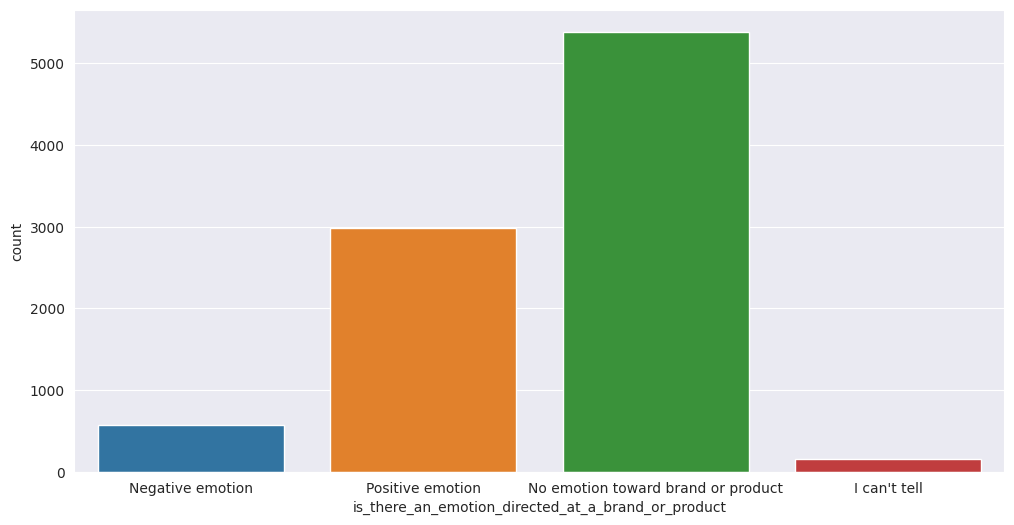

In [9]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=data)

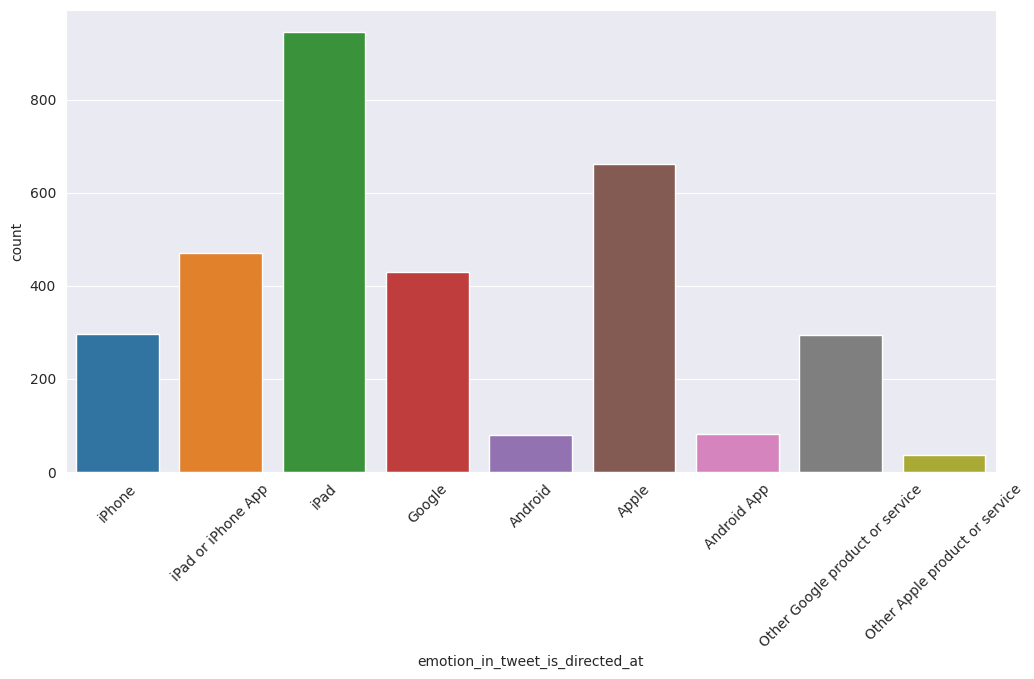

In [10]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=data)
plt.xticks(rotation=45);

In [11]:
# Create a working dataframe with easier column name
df = data.copy(deep=True)
df.drop_duplicates(subset=['tweet_text'], inplace=True)
df.dropna(subset=['tweet_text'], inplace=True)
df.rename(columns = {'emotion_in_tweet_is_directed_at':'brand_item', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

# Convert the data types to string
df['tweet_text'] = df['tweet_text'].astype(str)
df['brand_item'] = df['brand_item'].astype(str)

# Brand name mapping
brand = {'iPhone': 'apple',
         'iPad or iPhone App':'apple',
         'iPad': 'apple',
         'Google': 'google',
         'nan': 'UNK',
         'Android':'google',
         'Apple': 'apple',
         'Android App':'google',
         'Other Google product or service':'google',
         'Other Apple product or service':'apple'
        }

df['brand_name'] = df['brand_item'].map(brand)

# Encoding class label to brief
label_encoder = {'Negative emotion': 'negative',
                 'Positive emotion': 'positive',
                 'No emotion toward brand or product': 'neutral',
                 "I can't tell":'confused'}

df['emotion'] = df['emotion'].map(label_encoder)
df = df[df['emotion'] != 'confused']    # drop the rows containing 'confused' labels

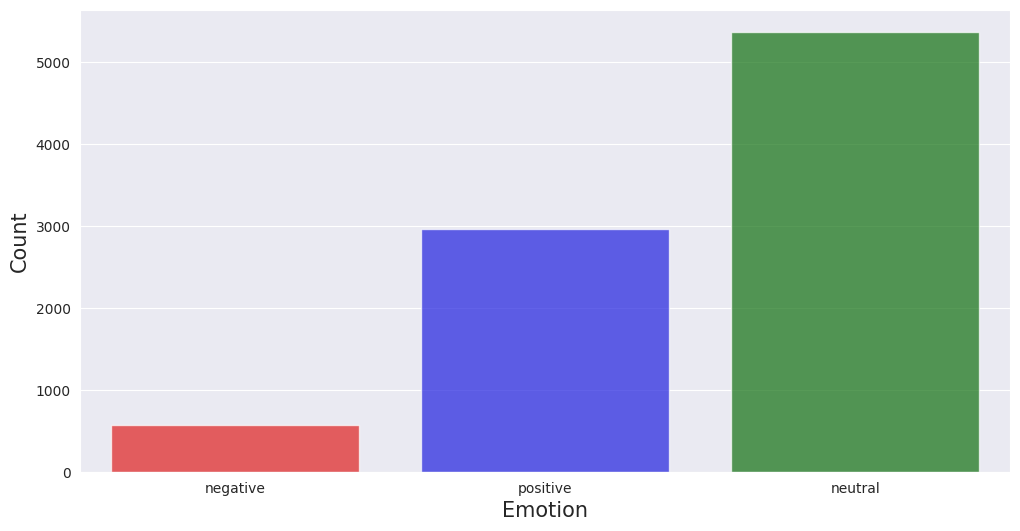

In [12]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,
              palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15);

In [13]:
df.emotion.value_counts(normalize=True)

neutral     0.602986
positive    0.333146
negative    0.063868
Name: emotion, dtype: float64

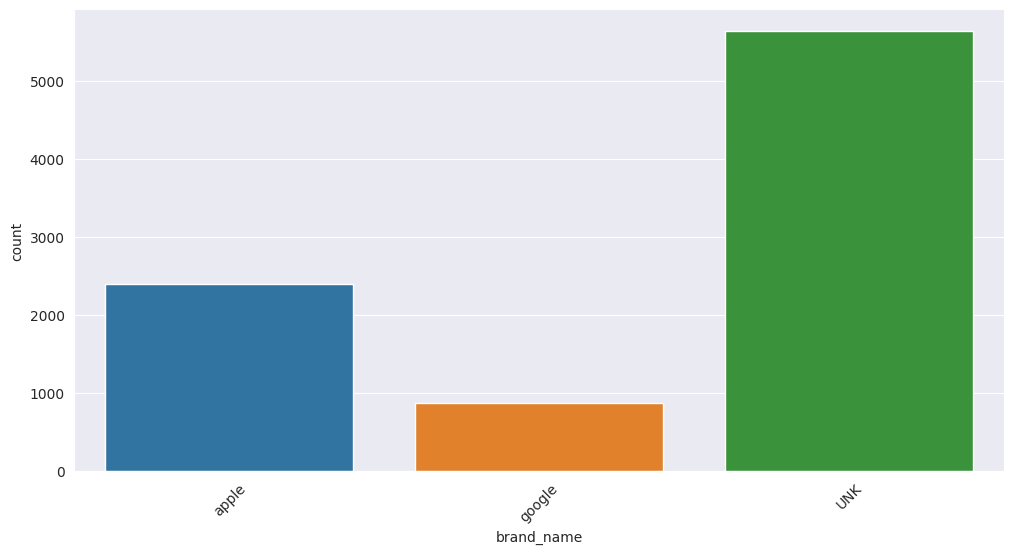

In [14]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='brand_name', data=df)
plt.xticks(rotation=45);

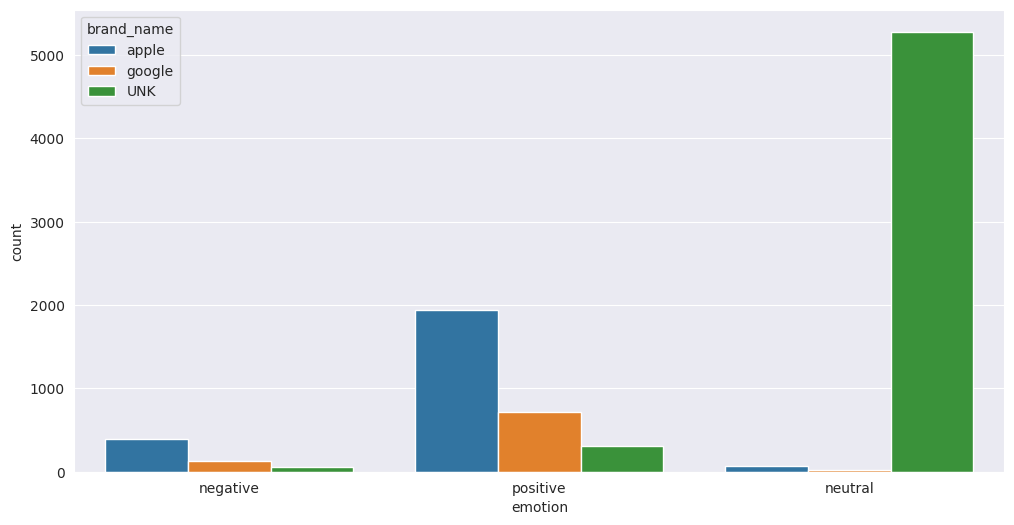

In [15]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'emotion', hue='brand_name')

In [16]:
df = df[['emotion', 'tweet_text']]
df.head()

,emotion,tweet_text
0,negative,.@wesley83 I have a 3G iPhone. After 3 hrs twe...
1,positive,@jessedee Know about @fludapp ? Awesome iPad/i...
2,positive,@swonderlin Can not wait for #iPad 2 also. The...
3,negative,@sxsw I hope this year's festival isn't as cra...
4,positive,@sxtxstate great stuff on Fri #SXSW: Marissa M...


Text(0, 0.5, 'Count')

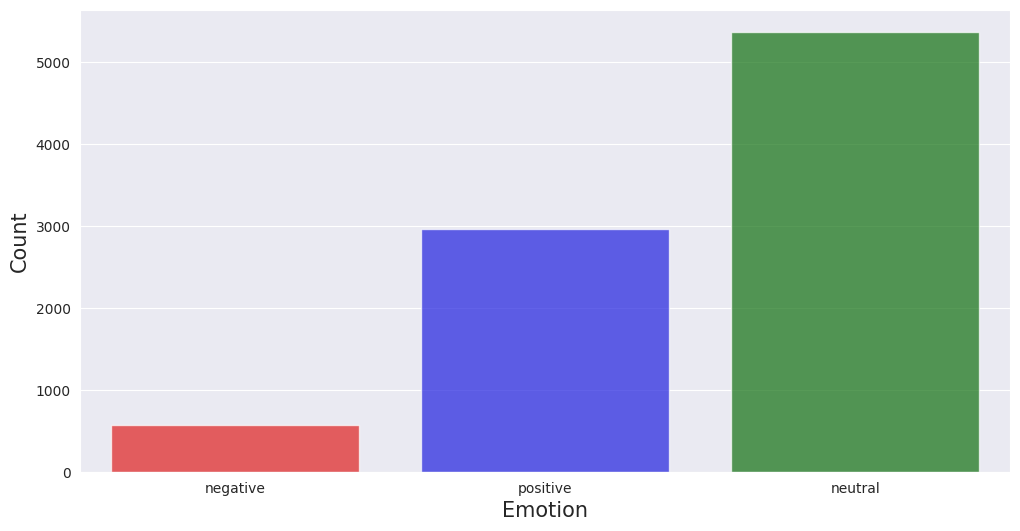

In [20]:
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='emotion', data=df,
             palette={'positive':'b', 'negative':'r', 'neutral':'g'}, alpha=0.7)
plt.xlabel('Emotion', fontsize=15)
plt.ylabel('Count', fontsize=15)

In [21]:
df.emotion.value_counts(normalize=True)

neutral     0.602986
positive    0.333146
negative    0.063868
Name: emotion, dtype: float64

In [22]:
df.tweet_text.head(10)

0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1     @jessedee Know about @fludapp ? Awesome iPad/i...
2     @swonderlin Can not wait for #iPad 2 also. The...
3     @sxsw I hope this year's festival isn't as cra...
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...
5     @teachntech00 New iPad Apps For #SpeechTherapy...
7     #SXSW is just starting, #CTIA is around the co...
8     Beautifully smart and simple idea RT @madebyma...
9     Counting down the days to #sxsw plus strong Ca...
10    Excited to meet the @samsungmobileus at #sxsw ...
Name: tweet_text, dtype: object

In [23]:
contraction_map = {"ain't": "is not", "aren't": "are not","can't": "cannot",
                   "can't've": "cannot have", "'cause": "because", "could've": "could have",
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not",
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not",
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will",
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did",
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                   "I'll've": "I will have","I'm": "I am", "I've": "I have",
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will",
                   "i'll've": "i will have","i'm": "i am", "i've": "i have",
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                   "it'll": "it will", "it'll've": "it will have","it's": "it is",
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not",
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have",
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have",
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have",
                   "she's": "she is", "should've": "should have", "shouldn't": "should not",
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is",
                   "there'd": "there would", "there'd've": "there would have","there's": "there is",
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                   "they'll've": "they will have", "they're": "they are", "they've": "they have",
                   "to've": "to have", "wasn't": "was not", "we'd": "we would",
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                   "we're": "we are", "we've": "we have", "weren't": "were not",
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                   "what's": "what is", "what've": "what have", "when's": "when is",
                   "when've": "when have", "where'd": "where did", "where's": "where is",
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have",
                   "who's": "who is", "who've": "who have", "why's": "why is",
                   "why've": "why have", "will've": "will have", "won't": "will not",
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [24]:
def contraction_mapping(text):
    '''
    Function to map contraction to the text.
    '''

    apostrophe_handled = re.sub("’", "'", text)
    expanded = ' '.join([contraction_map[t] if t in contraction_map else t for t in apostrophe_handled.split(" ")])


    return expanded

In [25]:
# Test the function
row = 11
print('Before contraction:', '\n',  df['tweet_text'][row])
print('\nAfter contraction:', '\n', contraction_mapping(df['tweet_text'][row]))

Before contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.

After contraction: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.


In [26]:
# Apply contraction mapping
df['expanded_tweets'] = df['tweet_text'].apply(contraction_mapping)

In [27]:
def tweet_cleaner(tweet):
    '''
    Function to remove punctuations, special characters, html links, twitter handels etc...
    '''

    stopwords = ['rt','rts', 'retweet', 'quot', 'sxsw']

    punctuation = set(string.punctuation) # punctuation of English language
    punctuation.remove('#') # remove # so hashtags remain in x

    x = tweet
    x = re.sub(r'https?:\/\/\S+', '', x) # remove URL references
    x = re.sub(r'{link}', '', x)  # remove placeholders
    x = re.sub(r'@[\w]*', '', x) # remove @mention users
    x = re.sub('[^A-Za-z0-9]+', ' ', x) # remove @mention users
    x = re.sub(r'\b[0-9]+\b', '', x) # remove stand-alone numbers
    x = re.sub(r'&[a-z]+;', '', x) # remove HTML reference characters
    x = ''.join(ch for ch in x if ch not in punctuation) # remove punctuation
    x = x.replace("[^a-zA-z#]", " ")  #remove special characters

    x = [word.lower() for word in x.split() if word.lower() not in stopwords]
    x = [w for w in x if len(w)>2]

    return ' '.join(x)

In [28]:
# Test the function
row = 11
print('Before cleanup:', '\n',  df['expanded_tweets'][row])
print('\nAfter cleanup:', '\n', tweet_cleaner(df['expanded_tweets'][row]))

Before cleanup: 
 Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I cannot wait til the Android app comes out.

After cleanup: 
 find amp start impromptu parties with cannot wait til the android app comes out


In [29]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets1'] = df['expanded_tweets'].apply(tweet_cleaner)

# Word count of all the vocabulary
FreqDist(df['clean_tweets1'].unique().sum().split())

FreqDist({'the': 3253, 'for': 1875, 'ipad': 1653, 'apple': 1457, 'google': 1401, 'and': 1229, 'iphone': 1109, 'store': 1047, 'you': 712, 'new': 678, ...})

In [30]:
def remove_stopwords(tweet):
    stopwords_removed = [word for word in tweet.split() if word not in stopwords.words('english')]
    return ' '.join(stopwords_removed)

In [31]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets2'] = df['clean_tweets1'].apply(remove_stopwords)

# Word count of all the vocabulary
FreqDist(df['clean_tweets2'].unique().sum().split())

FreqDist({'ipad': 1571, 'apple': 1386, 'google': 1310, 'iphone': 1053, 'store': 1018, 'new': 660, 'austin': 601, 'amp': 595, 'app': 550, 'pop': 452, ...})

In [32]:
df

,emotion,tweet_text,expanded_tweets,clean_tweets1,clean_tweets2
0,negative,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...
1,positive,@jessedee Know about @fludapp ? Awesome iPad/i...,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...
2,positive,@swonderlin Can not wait for #iPad 2 also. The...,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale
3,negative,@sxsw I hope this year's festival isn't as cra...,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app
4,positive,@sxtxstate great stuff on Fri #SXSW: Marissa M...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...
9088,positive,Ipad everywhere. #SXSW {link},Ipad everywhere. #SXSW {link},ipad everywhere,ipad everywhere
9089,neutral,"Wave, buzz... RT @mention We interrupt your re...","Wave, buzz... RT @mention We interrupt your re...",wave buzz interrupt your regularly scheduled g...,wave buzz interrupt regularly scheduled geek p...
9090,neutral,"Google's Zeiger, a physician never reported po...","Google's Zeiger, a physician never reported po...",google zeiger physician never reported potenti...,google zeiger physician never reported potenti...
9091,neutral,Some Verizon iPhone customers complained their...,Some Verizon iPhone customers complained their...,some verizon iphone customers complained their...,verizon iphone customers complained time fell ...


In [33]:
def normalization(tweet):
    lem = WordNetLemmatizer()
    normalized_tweet = []
    for word in tweet.split():
        normalized_text = lem.lemmatize(word, 'v')
        normalized_tweet.append(normalized_text)
    return ' '.join(normalized_tweet)

In [34]:
# Apply the tweet cleaner to whole dataframe
df['clean_tweets3'] = df['clean_tweets2'].apply(normalization)

# Word count of all the vocabulary
FreqDist(df['clean_tweets3'].unique().sum().split())

FreqDist({'ipad': 1569, 'apple': 1385, 'google': 1308, 'iphone': 1052, 'store': 1046, 'new': 658, 'austin': 601, 'amp': 592, 'app': 549, 'pop': 461, ...})

In [35]:
df

,emotion,tweet_text,expanded_tweets,clean_tweets1,clean_tweets2,clean_tweets3
0,negative,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,have iphone after hrs tweeting rise austin was...,iphone hrs tweeting rise austin dead need upgr...,iphone hrs tweet rise austin dead need upgrade...
1,positive,@jessedee Know about @fludapp ? Awesome iPad/i...,@jessedee Know about @fludapp ? Awesome iPad/i...,know about awesome ipad iphone app that you wi...,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,positive,@swonderlin Can not wait for #iPad 2 also. The...,@swonderlin Can not wait for #iPad 2 also. The...,can not wait for ipad also they should sale th...,wait ipad also sale,wait ipad also sale
3,negative,@sxsw I hope this year's festival isn't as cra...,@sxsw I hope this year's festival is not as cr...,hope this year festival not crashy this year i...,hope year festival crashy year iphone app,hope year festival crashy year iphone app
4,positive,@sxtxstate great stuff on Fri #SXSW: Marissa M...,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...,great stuff fri marissa mayer google tim reill...
...,...,...,...,...,...,...
9088,positive,Ipad everywhere. #SXSW {link},Ipad everywhere. #SXSW {link},ipad everywhere,ipad everywhere,ipad everywhere
9089,neutral,"Wave, buzz... RT @mention We interrupt your re...","Wave, buzz... RT @mention We interrupt your re...",wave buzz interrupt your regularly scheduled g...,wave buzz interrupt regularly scheduled geek p...,wave buzz interrupt regularly schedule geek pr...
9090,neutral,"Google's Zeiger, a physician never reported po...","Google's Zeiger, a physician never reported po...",google zeiger physician never reported potenti...,google zeiger physician never reported potenti...,google zeiger physician never report potential...
9091,neutral,Some Verizon iPhone customers complained their...,Some Verizon iPhone customers complained their...,some verizon iphone customers complained their...,verizon iphone customers complained time fell ...,verizon iphone customers complain time fell ba...


In [36]:
X = df[['clean_tweets2']]
y = df['emotion']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815, 1), (1203, 1), (891, 1), (6815,), (1203,), (891,))

In [38]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets2']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets2']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets2']).toarray()

In [39]:
X_train_vec.shape, X_val_vec.shape

((6815, 7888), (1203, 7888))

In [40]:
X_train

,clean_tweets2
3372,omg guy next brand new ipad trying understand ...
136,beautiful apple store pic
3331,google circles lame
6851,video first ipad2 unboxing outside apple store...
3027,almost every answered google docs session loos...
...,...
7430,apple pops store event like think amp could le...
3097,android developers meetup hilton
4090,tech apple heads sets temporary store austin
3274,got given free portable iphone charger sweet t...


In [41]:
# Simple Naive Bayes classifer
clf1_NB = MultinomialNB()
clf1_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [42]:
def get_prediction(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print('Training Prediction')
    print('--------------------')
    print(classification_report(y_train, y_train_pred))
    print('Test Prediction')
    print('--------------------')
    print(classification_report(y_test, y_test_pred))

    return y_train_pred, y_test_pred

In [43]:
_, _ = get_prediction(clf1_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.95      0.04      0.08       435
     neutral       0.74      0.98      0.84      4110
    positive       0.90      0.52      0.66      2270

    accuracy                           0.77      6815
   macro avg       0.86      0.51      0.53      6815
weighted avg       0.80      0.77      0.73      6815

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       1.00      0.06      0.12        77
     neutral       0.66      0.93      0.77       725
    positive       0.65      0.28      0.39       401

    accuracy                           0.66      1203
   macro avg       0.77      0.42      0.43      1203
weighted avg       0.67      0.66      0.60      1203



In [44]:
# Instantiate a Random Forest Classifier
clf_rf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6, class_weight='balanced')
clf_rf.fit(X_train_vec, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=6, random_state=0)

In [45]:
# Next we try to fit Naive Bayes on lemmatized data
X = df[['clean_tweets3']]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815, 1), (1203, 1), (891, 1), (6815,), (1203,), (891,))

In [47]:
# Vectorizing
tfidf_vectorizer = TfidfVectorizer()

X_train_vec = tfidf_vectorizer.fit_transform(X_train['clean_tweets3']).toarray()
X_test_vec = tfidf_vectorizer.transform(X_test['clean_tweets3']).toarray()
X_val_vec = tfidf_vectorizer.transform(X_val['clean_tweets3']).toarray()

In [48]:
# Simple Naive Bayes classifer
clf2_NB = MultinomialNB()
clf2_NB.fit(X_train_vec, y_train)

MultinomialNB()

In [49]:
_, _ = get_prediction(clf2_NB, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.93      0.03      0.06       435
     neutral       0.72      0.98      0.83      4110
    positive       0.90      0.48      0.63      2270

    accuracy                           0.76      6815
   macro avg       0.85      0.50      0.51      6815
weighted avg       0.80      0.76      0.72      6815

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       1.00      0.06      0.12        77
     neutral       0.66      0.93      0.77       725
    positive       0.65      0.28      0.39       401

    accuracy                           0.66      1203
   macro avg       0.77      0.42      0.43      1203
weighted avg       0.68      0.66      0.60      1203



In [50]:
# Instantiate a Random Forest Classifier
clf_rf2 = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=6)
clf_rf2.fit(X_train_vec, y_train)

RandomForestClassifier(n_jobs=6, random_state=0)

In [51]:
_, _ = get_prediction(clf_rf2, X_train_vec, X_val_vec, y_train, y_val)

Training Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.97      0.93      0.95       435
     neutral       0.95      0.98      0.97      4110
    positive       0.97      0.92      0.95      2270

    accuracy                           0.96      6815
   macro avg       0.97      0.94      0.95      6815
weighted avg       0.96      0.96      0.96      6815

Test Prediction
--------------------
              precision    recall  f1-score   support

    negative       0.62      0.23      0.34        77
     neutral       0.70      0.85      0.77       725
    positive       0.63      0.47      0.54       401

    accuracy                           0.68      1203
   macro avg       0.65      0.52      0.55      1203
weighted avg       0.67      0.68      0.66      1203



In [52]:
import warnings
warnings.filterwarnings('ignore')

In [53]:
X = df['clean_tweets1']
y_ohe = pd.get_dummies(df['emotion'])
print(X.iloc[:3], y_ohe.iloc[:3])

0    have iphone after hrs tweeting rise austin was...
1    know about awesome ipad iphone app that you wi...
2    can not wait for ipad also they should sale th...
Name: clean_tweets1, dtype: object    negative  neutral  positive
0         1        0         0
1         0        0         1
2         0        0         1


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.10, stratify=y_ohe,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train,
                                                  random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((6815,), (1203,), (891,), (6815, 3), (1203, 3), (891, 3))

In [55]:
def create_tokens(X_train, X_val, X_test):
    '''
    A simple function to create word tokens with padded sequences
    '''
    tokenizer = Tokenizer(oov_token=True)
    tokenizer.fit_on_texts(X_train)

    X_train_token = tokenizer.texts_to_sequences(X_train)
    X_test_token = tokenizer.texts_to_sequences(X_test)
    X_val_token = tokenizer.texts_to_sequences(X_val)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = len(max(X_train_token, key=lambda x: len(x)))
    maxlen_orig= len(max(X_train, key=lambda x: len(x)))

    X_train_seq = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
    X_test_seq = pad_sequences(X_test_token, padding='post', maxlen=maxlen)
    X_val_seq = pad_sequences(X_val_token, padding='post', maxlen=maxlen)

    print(f"Token count: {tokenizer.document_count}, Vocab size: {vocab_size}, Max lenth: {maxlen}, Original length: {maxlen_orig}")

    return X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer

In [56]:
X_train_seq, X_test_seq, X_val_seq, maxlen, vocab_size, tokenizer = create_tokens(X_train, X_val, X_test)

Token count: 6815, Vocab size: 8071, Max lenth: 23, Original length: 129


In [57]:
# Helper function: Define callbacks and save final model

def predict(model, epochs, batch_size):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model/cp.ckpt', monitor='val_loss',
                             save_weights_only = True,
                             save_best_only=True)]

    history = model.fit(X_train_seq, y_train,
                     batch_size=batch_size, epochs=epochs, verbose=1,
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                       )

#     graph_model(history, 'loss')
#     graph_model(history, 'accuracy')

    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)

    return history, train_prediction, val_prediction, test_prediction,

In [58]:
def graph_model(history, metrics):
    plt.plot(history.history[metrics])
    plt.plot(history.history['val_'+ metrics])
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend(['training', 'test'], loc='upper right')
    plt.show()

In [59]:
# Train a simple LSTM model

embed_dim=128

model_lstm1 = Sequential()
model_lstm1.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 100,
                    input_length = maxlen))
model_lstm1.add(layers.LSTM(embed_dim, return_sequences=True))
model_lstm1.add(layers.GlobalMaxPool1D())
model_lstm1.add(layers.Dropout(0.2))
model_lstm1.add(layers.Dense(64, activation='relu'))
model_lstm1.add(layers.Dense(3, activation='softmax'))

model_lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 100)           807100    
                                                                 
 lstm (LSTM)                 (None, 23, 128)           117248    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                        

In [60]:
history_lstm1, _, _, _ = predict(model_lstm1, 20, 32)

Epoch 1/20
213/213 [==============================] - 17s 64ms/step - loss: 0.8150 - accuracy: 0.6330 - val_loss: 0.7515 - val_accuracy: 0.6658
Epoch 2/20
213/213 [==============================] - 13s 60ms/step - loss: 0.6291 - accuracy: 0.7335 - val_loss: 0.7271 - val_accuracy: 0.6750
Epoch 3/20
213/213 [==============================] - 13s 60ms/step - loss: 0.4528 - accuracy: 0.8131 - val_loss: 0.7847 - val_accuracy: 0.6825
Epoch 4/20
213/213 [==============================] - 13s 61ms/step - loss: 0.3323 - accuracy: 0.8643 - val_loss: 0.9522 - val_accuracy: 0.6650
Epoch 5/20
213/213 [==============================] - 14s 67ms/step - loss: 0.2662 - accuracy: 0.8954 - val_loss: 1.0976 - val_accuracy: 0.6592
Epoch 6/20
213/213 [==============================] - 17s 79ms/step - loss: 0.2264 - accuracy: 0.9081 - val_loss: 1.1895 - val_accuracy: 0.6592
Epoch 7/20
28/28 [==============================] - 0s 14ms/step


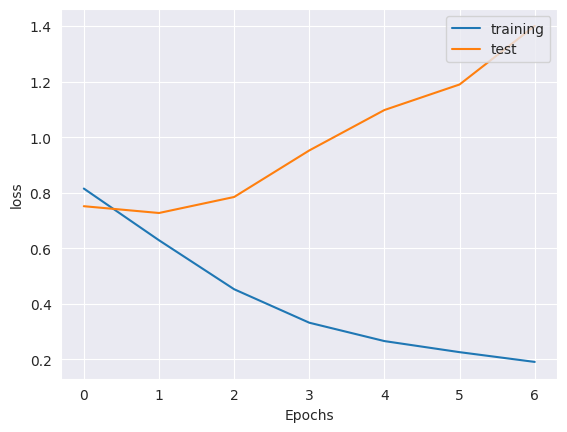

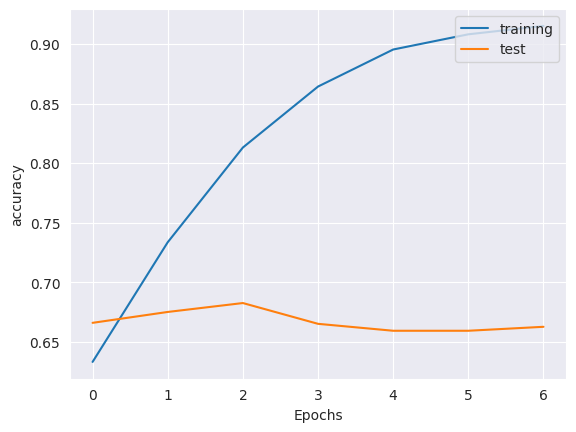

In [61]:
graph_model(history_lstm1, 'loss')
graph_model(history_lstm1, 'accuracy')

In [62]:
# LSTM model - Bidirectional
embed_dim=128

model_lstm2 = Sequential()
model_lstm2.add(layers.Embedding(input_dim = vocab_size,
                    output_dim = 128,
                    input_length = maxlen))
model_lstm2.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm2.add(layers.GlobalMaxPool1D())
model_lstm2.add(layers.Dropout(0.2))
model_lstm2.add(layers.Dense(64, activation='relu'))
model_lstm2.add(layers.Dense(3, activation='softmax'))

model_lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 128)           1033088   
                                                                 
 bidirectional (Bidirection  (None, 23, 256)           263168    
 al)                                                             
                                                                 
 global_max_pooling1d_1 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 3)                

In [63]:
history_lstm2, _, _, _ = predict(model_lstm2, 20, 32)

Epoch 1/20
213/213 [==============================] - 31s 124ms/step - loss: 0.8094 - accuracy: 0.6357 - val_loss: 0.7678 - val_accuracy: 0.6667
Epoch 2/20
213/213 [==============================] - 25s 119ms/step - loss: 0.6195 - accuracy: 0.7391 - val_loss: 0.7384 - val_accuracy: 0.6509
Epoch 3/20
213/213 [==============================] - 22s 105ms/step - loss: 0.4416 - accuracy: 0.8239 - val_loss: 0.7856 - val_accuracy: 0.6941
Epoch 4/20
213/213 [==============================] - 24s 114ms/step - loss: 0.3225 - accuracy: 0.8703 - val_loss: 0.9783 - val_accuracy: 0.6675
Epoch 5/20
213/213 [==============================] - 22s 106ms/step - loss: 0.2527 - accuracy: 0.8946 - val_loss: 1.0797 - val_accuracy: 0.6683
Epoch 6/20
213/213 [==============================] - 24s 114ms/step - loss: 0.2052 - accuracy: 0.9117 - val_loss: 1.2583 - val_accuracy: 0.6567
Epoch 7/20
28/28 [==============================] - 1s 24ms/step


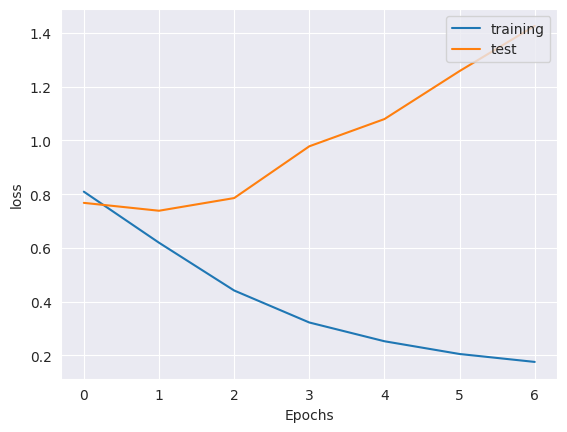

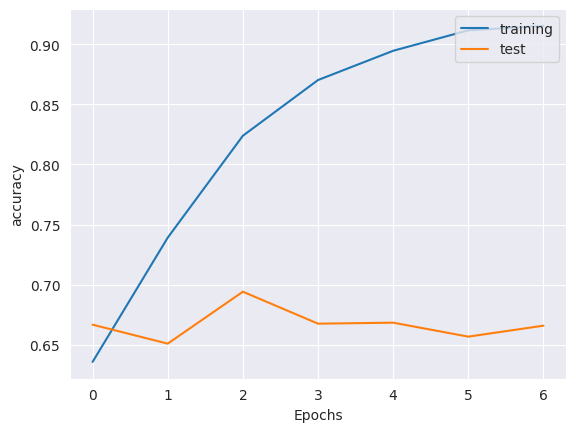

In [64]:
graph_model(history_lstm2, 'loss')
graph_model(history_lstm2, 'accuracy')

In [66]:
print(f'found {len(embeddings_index)} word vectors.')

found 0 word vectors.


In [67]:
# Create a weight matrix for work vocabulary from our training set

embedding_matrix = np.zeros((vocab_size, 100))  # 100 for 100-dimensional version
for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 8070/8070 [00:00<00:00, 451367.29it/s]


In [68]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm3 = Sequential()
model_lstm3.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_lstm3.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm3.add(layers.GlobalMaxPool1D())
model_lstm3.add(layers.Dropout(0.2))
model_lstm3.add(layers.Dense(64, activation='relu'))
model_lstm3.add(layers.Dense(3, activation='softmax'))

model_lstm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 23, 100)           807100    
                                                                 
 bidirectional_1 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 3)                

In [69]:
hist_lstm3, train_lstm3, val_lstm3, test_lstm3 = predict(model_lstm3, 20, 32)

Epoch 1/20
213/213 [==============================] - 24s 86ms/step - loss: 1.0493 - accuracy: 0.5978 - val_loss: 1.0061 - val_accuracy: 0.6027
Epoch 2/20
213/213 [==============================] - 17s 82ms/step - loss: 0.9743 - accuracy: 0.6031 - val_loss: 0.9469 - val_accuracy: 0.6027
Epoch 3/20
213/213 [==============================] - 17s 82ms/step - loss: 0.9267 - accuracy: 0.6031 - val_loss: 0.9096 - val_accuracy: 0.6027
Epoch 4/20
213/213 [==============================] - 17s 79ms/step - loss: 0.8970 - accuracy: 0.6031 - val_loss: 0.8865 - val_accuracy: 0.6027
Epoch 5/20
213/213 [==============================] - 19s 91ms/step - loss: 0.8784 - accuracy: 0.6031 - val_loss: 0.8721 - val_accuracy: 0.6027
Epoch 6/20
213/213 [==============================] - 17s 80ms/step - loss: 0.8669 - accuracy: 0.6031 - val_loss: 0.8630 - val_accuracy: 0.6027
Epoch 7/20
213/213 [==============================] - 18s 82ms/step - loss: 0.8596 - accuracy: 0.6031 - val_loss: 0.8572 - val_accuracy:

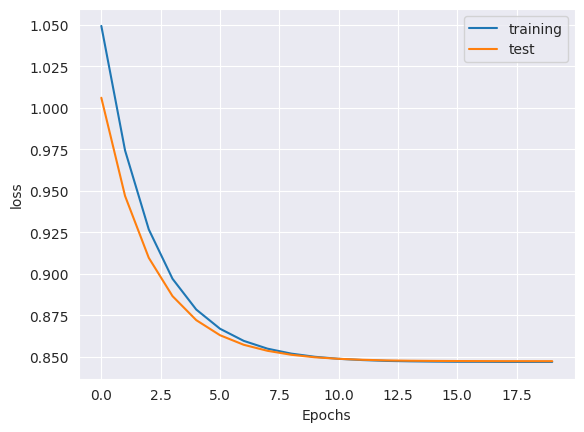

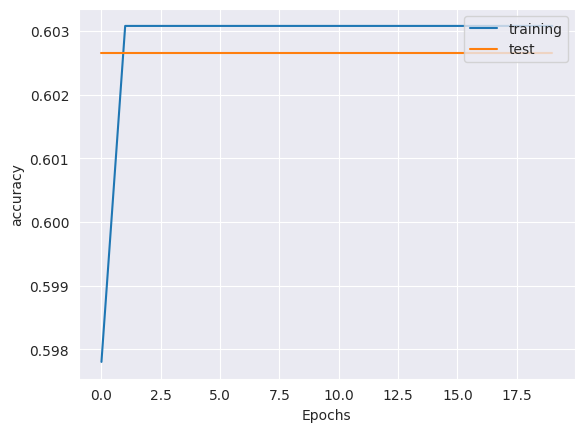

In [70]:
graph_model(hist_lstm3, 'loss')
graph_model(hist_lstm3, 'accuracy')

In [71]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm4 = Sequential()
model_lstm4.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_lstm4.add(layers.Dropout(0.4))
model_lstm4.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm4.add(layers.GlobalMaxPool1D())
model_lstm4.add(layers.Dropout(0.2))
model_lstm4.add(layers.Dense(64, activation='relu'))
model_lstm4.add(layers.Dense(3, activation='softmax'))

model_lstm4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_3 (Dropout)         (None, 23, 100)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_3 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [72]:
hist_lstm4, train_lstm4, val_lstm4, _ = predict(model_lstm4, 20, 32)

Epoch 1/20
213/213 [==============================] - 25s 96ms/step - loss: 1.0495 - accuracy: 0.6009 - val_loss: 1.0063 - val_accuracy: 0.6027
Epoch 2/20
213/213 [==============================] - 17s 81ms/step - loss: 0.9744 - accuracy: 0.6031 - val_loss: 0.9468 - val_accuracy: 0.6027
Epoch 3/20
213/213 [==============================] - 17s 81ms/step - loss: 0.9268 - accuracy: 0.6031 - val_loss: 0.9099 - val_accuracy: 0.6027
Epoch 4/20
213/213 [==============================] - 18s 82ms/step - loss: 0.8971 - accuracy: 0.6031 - val_loss: 0.8867 - val_accuracy: 0.6027
Epoch 5/20
213/213 [==============================] - 17s 82ms/step - loss: 0.8785 - accuracy: 0.6031 - val_loss: 0.8721 - val_accuracy: 0.6027
Epoch 6/20
213/213 [==============================] - 20s 95ms/step - loss: 0.8669 - accuracy: 0.6031 - val_loss: 0.8629 - val_accuracy: 0.6027
Epoch 7/20
213/213 [==============================] - 18s 85ms/step - loss: 0.8596 - accuracy: 0.6031 - val_loss: 0.8573 - val_accuracy:

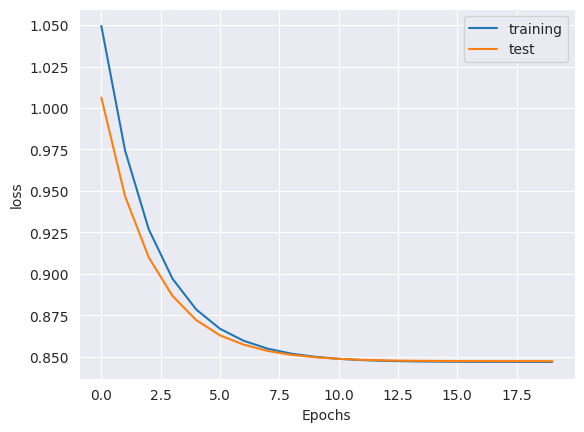

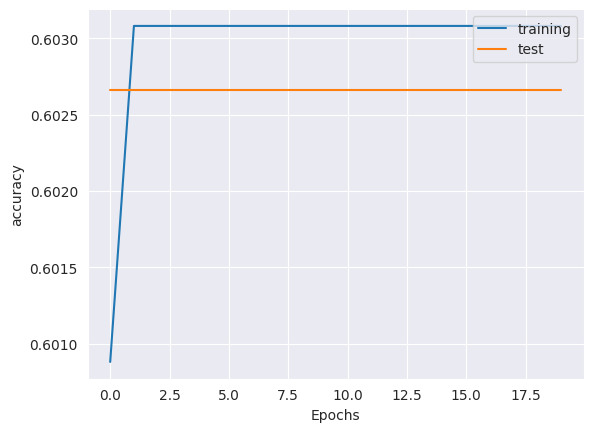

In [73]:
graph_model(hist_lstm4, 'loss')
graph_model(hist_lstm4, 'accuracy')

In [74]:
def predict_df(y_true, y_pred):
    '''
    A simple function to put predicted results into a dataframe
    '''

    true_df = pd.DataFrame(y_true.idxmax(axis=1), columns=['true_emotion']).reset_index(drop=True)

    pred_df = pd.DataFrame(y_pred.argmax(axis=1), columns=['predicted'])
    pred_df['predicted'] = pred_df['predicted'].apply(lambda x: 'negative' if x==0
                                                     else 'neutral' if x==1
                                                     else 'positive' )

    merge_df = pd.merge(true_df, pred_df, left_index=True, right_index=True)

    print(classification_report(merge_df['true_emotion'], merge_df['predicted']))

    return merge_df

In [75]:
train_predict_df = predict_df(y_train, train_lstm4)
val_predict_df = predict_df(y_val, val_lstm4)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       435
     neutral       0.60      1.00      0.75      4110
    positive       0.00      0.00      0.00      2270

    accuracy                           0.60      6815
   macro avg       0.20      0.33      0.25      6815
weighted avg       0.36      0.60      0.45      6815

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        77
     neutral       0.60      1.00      0.75       725
    positive       0.00      0.00      0.00       401

    accuracy                           0.60      1203
   macro avg       0.20      0.33      0.25      1203
weighted avg       0.36      0.60      0.45      1203



In [76]:
model_gru1 = Sequential()
model_gru1.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_gru1.add(layers.Dropout(0.4))
model_gru1.add(layers.GRU(100))
model_gru1.add(layers.Flatten())
model_gru1.add(layers.Dropout(0.2))
model_gru1.add(layers.Dense(64, activation='relu'))
model_gru1.add(layers.Dense(3, activation='softmax'))

model_gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru1.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_5 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru (GRU)                   (None, 100)               60600     
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                6464      
                                                                 
 dense_9 (Dense)             (None, 3)                

In [77]:
hist_gru1, train_gru1, val_gru1, test_gru1 = predict(model_gru1, 20, 32)

Epoch 1/20
213/213 [==============================] - 12s 24ms/step - loss: 1.0501 - accuracy: 0.6004 - val_loss: 1.0068 - val_accuracy: 0.6027
Epoch 2/20
213/213 [==============================] - 5s 24ms/step - loss: 0.9746 - accuracy: 0.6031 - val_loss: 0.9468 - val_accuracy: 0.6027
Epoch 3/20
213/213 [==============================] - 6s 28ms/step - loss: 0.9267 - accuracy: 0.6031 - val_loss: 0.9096 - val_accuracy: 0.6027
Epoch 4/20
213/213 [==============================] - 5s 22ms/step - loss: 0.8969 - accuracy: 0.6031 - val_loss: 0.8864 - val_accuracy: 0.6027
Epoch 5/20
213/213 [==============================] - 6s 27ms/step - loss: 0.8783 - accuracy: 0.6031 - val_loss: 0.8720 - val_accuracy: 0.6027
Epoch 6/20
213/213 [==============================] - 5s 25ms/step - loss: 0.8668 - accuracy: 0.6031 - val_loss: 0.8630 - val_accuracy: 0.6027
Epoch 7/20
213/213 [==============================] - 5s 22ms/step - loss: 0.8595 - accuracy: 0.6031 - val_loss: 0.8572 - val_accuracy: 0.602

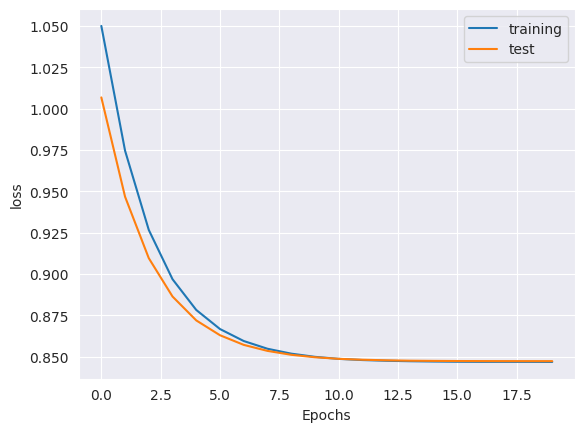

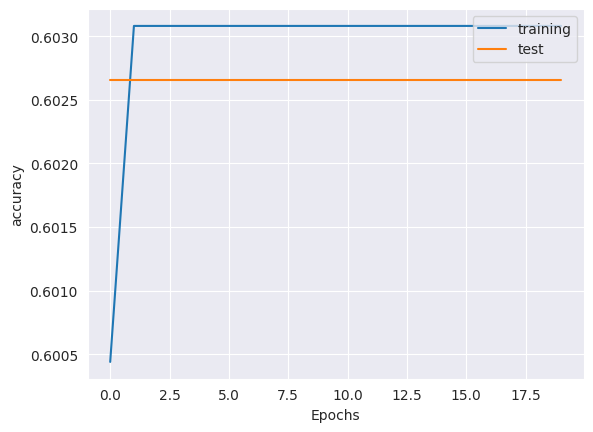

In [78]:
graph_model(hist_gru1, 'loss')
graph_model(hist_gru1, 'accuracy')

In [79]:
train_predict_df = predict_df(y_train, train_gru1)
val_predict_df = predict_df(y_val, val_gru1)

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       435
     neutral       0.60      1.00      0.75      4110
    positive       0.00      0.00      0.00      2270

    accuracy                           0.60      6815
   macro avg       0.20      0.33      0.25      6815
weighted avg       0.36      0.60      0.45      6815

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        77
     neutral       0.60      1.00      0.75       725
    positive       0.00      0.00      0.00       401

    accuracy                           0.60      1203
   macro avg       0.20      0.33      0.25      1203
weighted avg       0.36      0.60      0.45      1203



In [80]:
df.emotion.value_counts()/df.shape[0]

neutral     0.602986
positive    0.333146
negative    0.063868
Name: emotion, dtype: float64

In [81]:
y_ohe_numpy = y_ohe.to_numpy()

In [84]:
# Define callbacks and save final model
def predict_w(model, epochs, batch_size, weights):
    early_stop = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model_m.h5', monitor='val_loss',
                            save_best_only=True)]

    history = model.fit(X_train_seq, y_train,
                     batch_size=batch_size, epochs=epochs, verbose=1,
                     validation_data=(X_val_seq, y_val),
                     callbacks=early_stop,
                     class_weight=weights)

    graph_model(history, 'loss')
    graph_model(history, 'accuracy')

    train_prediction = model.predict(X_train_seq, batch_size=batch_size)
    val_prediction = model.predict(X_val_seq, batch_size=batch_size)
    test_prediction = model.predict(X_test_seq, batch_size=batch_size)

    return history, train_prediction, val_prediction, test_prediction

In [85]:
# LSTM model - Bidirectional with GLOVE embedding
embed_dim=128

model_lstm5 = Sequential()
model_lstm5.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_lstm5.add(layers.Dropout(0.4))
model_lstm5.add(layers.Bidirectional(layers.LSTM(embed_dim, return_sequences=True)))
model_lstm5.add(layers.GlobalMaxPool1D())
model_lstm5.add(layers.Dropout(0.2))
model_lstm5.add(layers.Dense(64, activation='relu'))
model_lstm5.add(layers.Dense(3, activation='softmax'))

model_lstm5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_lstm5.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_7 (Dropout)         (None, 23, 100)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 23, 256)           234496    
 onal)                                                           
                                                                 
 global_max_pooling1d_4 (Gl  (None, 256)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 64)               

In [88]:
# GRU
model_gru2 = Sequential()
model_gru2.add(layers.Embedding(input_dim = vocab_size, output_dim = 100,
                     weights=[embedding_matrix],
                     input_length=maxlen, trainable=False))
model_gru2.add(layers.Dropout(0.4))
model_gru2.add(layers.GRU(100))
model_gru2.add(layers.Flatten())
model_gru2.add(layers.Dropout(0.2))
model_gru2.add(layers.Dense(64, activation='relu'))
model_gru2.add(layers.Dense(3, activation='softmax'))

model_gru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_gru2.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 23, 100)           807100    
                                                                 
 dropout_9 (Dropout)         (None, 23, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                6464      
                                                                 
 dense_13 (Dense)            (None, 3)                

In [108]:
from wordcloud import WordCloud

In [109]:
def create_wordcloud(df, col):
    wordcloud = WordCloud(background_color='black').generate(str(col))
    plt.imshow(wordcloud, interpolation='bilinear', aspect='auto')
    plt.axis("off")
    plt.show()

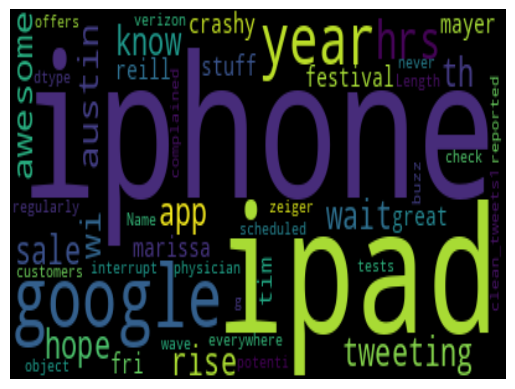

In [110]:
create_wordcloud(df.loc[df['emotion']=='negative'], df['clean_tweets1'])

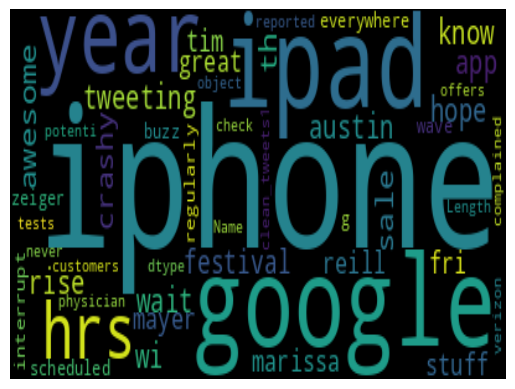

In [111]:
create_wordcloud(df.loc[df['emotion']=='positive'], df['clean_tweets1'])

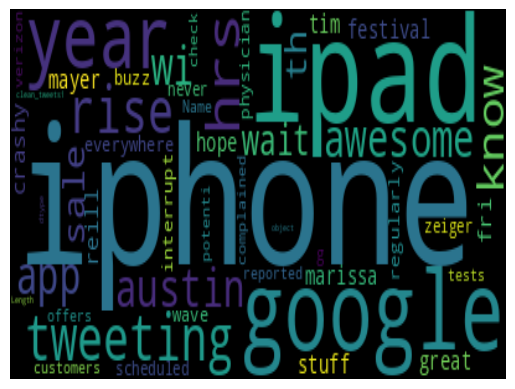

In [112]:
create_wordcloud(df.loc[df['emotion']=='neutral'], df['clean_tweets1'])